# Generation of figure 3
Tim Tyree<br>
1.3.2022

In [1]:
# TODO: simplify initialization
from scipy.optimize import minimize
from lib.my_initialization import *
from lib import *
from lib.lib_care.measure.level_sets import comp_longest_level_set_and_smooth
%load_ext autoreload
%autoreload 2

import random,scipy
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import CloughTocher2DInterpolator
import matplotlib as mpl #for colorbar
from scipy import stats

darkmode=False
if darkmode:
    # For darkmode plots
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

#optional
import cupy as cp
cp.random.seed(42)
np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# fit annihilation rates of the interacting inverse-powerlaw particle model to those of the full models
- method of fit: minimization of mean squared error of the powerlaw fits of the particle model to those of the full models
- method of minimization: Nelder-Mead minimization

In [2]:
#recall results from tables in the main mansucript
wjr=recall_powerlaw_fits_to_full_models()
interp=recall_particle_model_interp()
a_hat_FK, D_hat_FK, a_hat_FK_long, a_hat_FK_vlong, a_hat_LR, D_hat_LR, a_hat_LR_long=recall_particle_parameter_measurements()

estimated runtime is ~20 seconds for 17988 training samples...
number of training examples is 17988....
training complete!


a=8.595, D=0.586055, r=0.10413888309470609, kappa=559.500160485693, rmse=0.028075538795257697


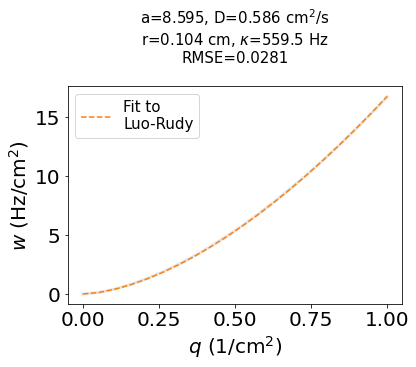

In [3]:
#fit the particle model to the luo-rudy model
dict_out_lr=PlotParticlModelAnnihilationRateFit(a=a_hat_LR,D=D_hat_LR,wjr=wjr,interp=interp,
    ax=None,model_name='lr_pbc',c='C1')

a=1.604153, D=0.365238, r=0.06045948522530842, kappa=495.2658318951493, rmse=0.006797222653889483


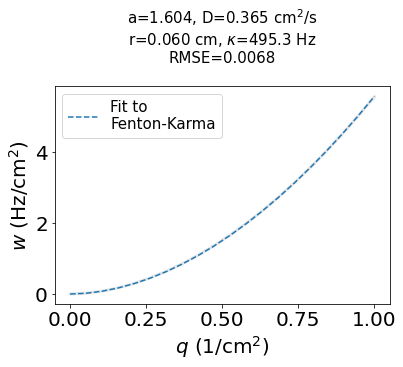

In [4]:
#fit the particle model to the fenton-karma model
dict_out_fk=PlotParticlModelAnnihilationRateFit(a=a_hat_FK_vlong,D=D_hat_FK,wjr=wjr,interp=interp,
    ax=None,model_name='fk_pbc',c='C0')

In [5]:
#recall ^these fits from lib
a,D,r,kappa,rmse=recall_particle_parameter_fits('luorudy')
print(f"a={a},    D={D}, r={r}, kappa={kappa},  rmse={rmse}")
a,D,r,kappa,rmse=recall_particle_parameter_fits('fentonkarma')
print(f"a={a}, D={D}, r={r}, kappa={kappa}, rmse={rmse}")

a=8.595,    D=0.586055, r=0.10413888309470609, kappa=559.500160485693,  rmse=0.028075538795257697
a=1.604153, D=0.365238, r=0.06045948522530842, kappa=495.2658318951493, rmse=0.006797222653889483


# TODO: plot each figure panel individually
HINT: consider automating the retrieval of xy data

In [6]:
# #GOAL(Fig. 3 in this ipynb)
# #DONE(Fig. 3): plot 
# #FK fit of particle model
# a=1.604153, D=0.365238, r=0.06045948522530842, kappa=495.2658318951493, rmse=0.006797222653889483
# #LR fit of particle model
# a=8.595, D=0.586055, r=0.10413888309470609, kappa=559.500160485693, rmse=0.028075538795257697
#TODO: plot each figure panel individually

In [7]:
#msr from the particle model
# npz_dir_FK='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_7.3923_D_0.365238.npz'#csv'
#msr from the full model
# msr_dir_fk='/home/timothytyree/Documents/GitHub/bgmc/python/data/full_results/msr_fk_boostrapped_tavg2_14.0_n_19087_a_1.6_tmax_300.csv'

#msr from the particle model
# npz_dir_LR='/home/timothytyree/Documents/GitHub/bgmc/python/data/control_data/arrays/control_a_8.595_D_0.586055.npz'#.csv'
